# How to use the package *hypnettorch*

The package ``hypnettorch`` provides a lot of useful features, its core purpose, however, is to provide an easy way to work with [hypernetworks](https://arxiv.org/abs/1609.09106) in [PyTorch](https://pytorch.org/).

To see how easy it is to get started and work with this package, we will walk through a basic example of training an MNIST/FashionMNIST classifier within a single hypernetwork.

In [ ]:
from IPython.display import display, Markdown, Latex
import numpy as np
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load the data

We first load the datasets used in this tutorial.

The data handlers in subpackage ``hypnettorch.data`` provide a consistent and convenient interface. It is, however, not required to use them. When using other data handlers, note that convolutional networks in subpackage ``hypnettorch.mnets`` by default expect a flattened input (see, for instance, option ``chw_input_format`` of class ``mnets.WRN``).

In [2]:
# Specify where to download the datasets?
data_dir = '.'

Reading MNIST dataset ...
Elapsed time to read dataset: 0.193871 sec


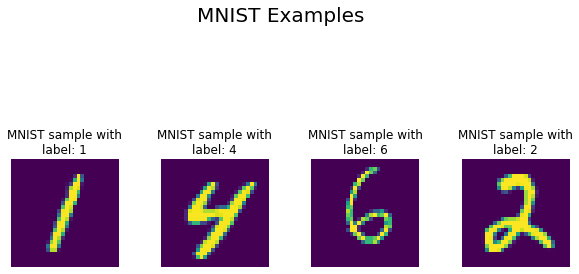

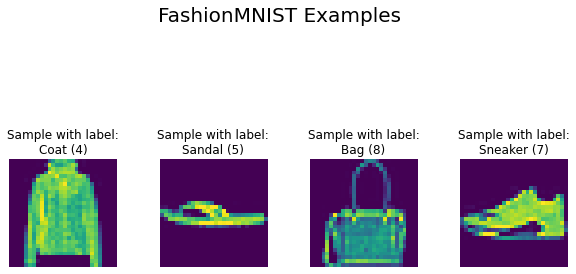

In [3]:
from hypnettorch.data import FashionMNISTData, MNISTData

mnist = MNISTData(data_dir, use_one_hot=True, validation_size=0)
fmnist = FashionMNISTData(data_dir, use_one_hot=True, validation_size=0)

# Get a batch of training samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_train_batch(4)
fmnist_inps, fmnist_trgts = fmnist.next_train_batch(4)

mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts)
fmnist.plot_samples('FashionMNIST Examples', fmnist_inps, outputs=fmnist_trgts)

## Instantiate the main network

A *hypernetwork* is a weight generator, it thus generates the weights of another network, which we call *main* or *target* network.

A variety of already implemented main networks can be found in subpackage ``hypnettorch.mnets``. Every main network must implement the interface ``hypnettorch.mnets.MainNetInterface``. One important aspect of this interface is, that network parameters can be passed as additional input to the ``forward`` method.

Most implemented networks have a constructor argument like ``no_weights``, which allows the instatiation with or without internal parameter tensors. If a network is instantiated with ``no_weights=True``, then weights have to be provided via the ``forward`` method, as the network has no internal weights to make inference.

In [4]:
from hypnettorch.mnets import MLP

num_pixel = np.prod(mnist.in_shape)

# Create a fully-connected network with and without internal parameters.
mlp_with = MLP(n_in=num_pixel, n_out=10, hidden_layers=[400,400],
               no_weights=False).to(device)

mlp_without = MLP(n_in=num_pixel, n_out=10, hidden_layers=[400,400],
                  no_weights=True).to(device)

for name, net in [('MLP with weights', mlp_with),
                  ('MLP without weights', mlp_without)]:
    display(Markdown('**%s**' % name))

    print('Num internal weights %d, num total %d.' % \
          (net.num_internal_params, net.num_params))

    print('Number of parameter tensors: %d' % \
          len(list(net.parameters())))

    ### Example forward pass (with randomly initialized network).
    # Note, the data handler returns the data as a numpy array, which
    # has to be translated to a torch tensor.
    mnist_inps, _ = mnist.next_train_batch(4)
    X = mnist.input_to_torch_tensor(mnist_inps, device, mode='train')
    
    try:
        Y = net.forward(X, weights=None)
        print('Predicted classes: ', Y.max(dim=1)[1])
    except:
        import sys
        import traceback
        display(Markdown('An **error** occured during the forward pass.'))
        traceback.print_exc(file=sys.stdout)

Creating an MLP with 478410 weights.
Creating an MLP with 478410 weights.


**MLP with weights**

Num internal weights 478410, num total 478410.
Number of parameter tensors: 6
Predicted classes:  tensor([8, 8, 2, 2])


**MLP without weights**

Num internal weights 0, num total 478410.
Number of parameter tensors: 0


An **error** occured during the forward pass.

Traceback (most recent call last):
  File "/tmp/ipykernel_11968/4169724310.py", line 29, in <module>
    Y = net.forward(X, weights=None)
  File "/home/christian/workspace/hypnettorch/hypnettorch/mnets/mlp.py", line 527, in forward
    raise Exception('Network was generated without weights. ' +
Exception: Network was generated without weights. Hence, "weights" option may not be None.


### Instantiate a small LeNet

For this tutorial, we work with a small convolutional network, which has no internal weights. Therefore, we later need to create a hypernetwork which can produce weights for this main network in order to make inference.

In [5]:
from hypnettorch.mnets import LeNet

mnet = LeNet(in_shape=mnist.in_shape, num_classes=mnist.num_classes,
             arch='mnist_small', no_weights=True)

Creating a LeNet with 21840 weights.


## Instantiate a hypernetwork

A variety of hypernetworks is available in subpackage ``hypnettorch.hnets``. The simplest being a fully-connected hypernetwork, see class ``hypnettorch.hnets.HMLP``. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, ``hypnettorch.hnets.ChunkedHMLP``). However, to keep this tutorial light, we don't discuss these options here.

All hypernetworks must implement the interface ``hypnettorch.hnets.HyperNetInterface``, which in turn implements ``hypnettorch.mnets.MainNetInterface``. Thus, every hypernetwork can also function as a main network (e.g., you can easily instantiate a hypernetwork of a hypernetwork).

Hypernetworks usually distinguish between two types of inputs: *conditional* and *unconditional* inputs. Conditional inputs are simply inputs that can be related to a finite and discrete set of conditions, such as the [task identity in continual learning](https://arxiv.org/abs/1906.00695). Simply speaking, conditional inputs can be used if the number $N$ of conditions is known a priori. In this case, the hypernetwork will create a set of $N$ learnable condition vectors (e.g., task embeddings), and can take the condition ID (as integer) as input to the ``forward`` method. This simplifies many usage scenarios, as the user of a hypernetwork does not have to maintain learnable input embeddings to the hypernetwork by himself. In all other cases (like the input to the hypernetwork comes from a continuous vector space), *unconditional* inputs should be used.

In our case, the hypernetwork should either generate a set of weights for MNIST (condition $0$) or FashionMNIST (condition $1$). Each of these conditions should internally be represented by a $8$-dimensional embedding vector.

In [6]:
from hypnettorch.hnets import HMLP

hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8,
            layers=[100, 100], num_cond_embs=2)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

# To produce main network weights for condition `0`, we can either pass
# the corresponding condition ID, or the corresponding (internally maintained)
# embedding to the `forward` of the hypernetwork.
W0 = hnet.forward(cond_id=0)
W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

# Hypernetworks also allow batch processing.
W_batch = hnet.forward(cond_id=[0, 0])
assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
               for i in range(len(W0))])

Created MLP Hypernet.
Hypernetwork with 2216856 weights and 21840 outputs (compression ratio: 101.50).
The network consists of 2216840 unconditional weights (2216840 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([-0.4294,  0.7109,  0.7438, -0.0707, -1.0180, -0.8410,  2.4450, -1.9270],
       requires_grad=True), Parameter containing:
tensor([-1.9397, -0.9431, -1.8001, -1.8449,  0.5752, -0.3523,  0.4383,  1.7646],
       requires_grad=True)]


**Hypernetwork initialization** can be an important factor, for instance, [when using optimizers such as SGD](https://openreview.net/forum?id=H1lma24tPB). Therefore, some hypernet implementations provide custom initialization functions.

In [7]:
hnet.apply_hyperfan_init(mnet=mnet)

**Making predictions** with the target network is fairly easy. Simply generate the corresponding weights with the hypernetwork and pass them to the ``forward`` method of the main network together with the network inputs. 

In [8]:
# Get a batch of main network inputs.
mnist_inps, _ = mnist.next_train_batch(4)
X = mnist.input_to_torch_tensor(mnist_inps, device, mode='train')

# Generate the main network weights for both conditions.
W = hnet.forward(cond_id=[0, 1])

Y0 = mnet.forward(X, weights=W[0])
print('Predicted classes for condition 0: ', Y0.max(dim=1)[1])

Y1 = mnet.forward(X, weights=W[1])
print('Predicted classes for condition 1: ', Y1.max(dim=1)[1])

Predicted classes for condition 0:  tensor([5, 5, 5, 5])
Predicted classes for condition 1:  tensor([5, 5, 5, 5])


## A complete training example

So far, we have seen how to instantiate and use networks. However, predictions weren't useful so far, as all parameters were still randomly initialized. Therefore, we now look at a simple example on how to train a hypernetwork.

In [9]:
def calc_accuracy(data, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

# Configure training.
lr=1e-4
batchsize=32
nepochs=10

# Adam usually works well in combination with hypernetwork training.
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.

    # Iterate over the whole MNIST/FashionMNIST training set.
    # Note, that both datasets have the same number of training samples.
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        # Current mini-batch of MNIST samples.
        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')
        
        # Current mini-batch of FashionMNIST samples.
        fx, fy = fmnist.next_train_batch(curr_batchsize)
        fmnist_X = fmnist.input_to_torch_tensor(fx, device, mode='train')
        fmnist_Y = fmnist.output_to_torch_tensor(fy, device, mode='train')

        optimizer.zero_grad()

        # Compute MNIST loss.
        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])
        
        # Compute FashionMNIST loss.
        W_fmnist = hnet(cond_id=1)
        fmnist_P = mnet.forward(fmnist_X, weights=W_fmnist)
        loss_fmnist = criterion(fmnist_P, fmnist_Y.max(dim=1)[1])
        
        # The total loss is simply each task's loss combined.
        loss = loss_mnist + loss_fmnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:            
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%, FashionMNIST acc: %.2f%%' %
                  (epoch + 1, i + 1, loss.item(), 
                   calc_accuracy(mnist, mnet, W_mnist),
                   calc_accuracy(fmnist, mnet, W_fmnist)))


print('Training finished with test-accs: MNIST acc: %.2f%%, FashionMNIST %.2f%%' % \
      (calc_accuracy(mnist, mnet, W_mnist),
       calc_accuracy(fmnist, mnet, W_fmnist)))

[1,   501] loss: 0.447, MNIST acc: 94.97%, FashionMNIST acc: 77.28%
[1,  1001] loss: 0.452, MNIST acc: 95.70%, FashionMNIST acc: 80.24%
[1,  1501] loss: 0.717, MNIST acc: 97.07%, FashionMNIST acc: 82.12%
[2,   501] loss: 1.039, MNIST acc: 96.14%, FashionMNIST acc: 82.87%
[2,  1001] loss: 0.494, MNIST acc: 97.89%, FashionMNIST acc: 81.61%
[2,  1501] loss: 0.560, MNIST acc: 98.11%, FashionMNIST acc: 84.34%
[3,   501] loss: 0.536, MNIST acc: 97.93%, FashionMNIST acc: 83.41%
[3,  1001] loss: 0.409, MNIST acc: 98.00%, FashionMNIST acc: 85.71%
[3,  1501] loss: 0.426, MNIST acc: 98.15%, FashionMNIST acc: 85.05%
[4,   501] loss: 0.372, MNIST acc: 98.07%, FashionMNIST acc: 84.50%
[4,  1001] loss: 0.279, MNIST acc: 97.91%, FashionMNIST acc: 86.26%
[4,  1501] loss: 0.629, MNIST acc: 97.63%, FashionMNIST acc: 84.18%
[5,   501] loss: 0.323, MNIST acc: 98.48%, FashionMNIST acc: 85.75%
[5,  1001] loss: 0.536, MNIST acc: 98.31%, FashionMNIST acc: 85.65%
[5,  1501] loss: 0.639, MNIST acc: 98.60%, Fashi

### Play with trained models

Now that the models are trained, we can checkout how they perform.

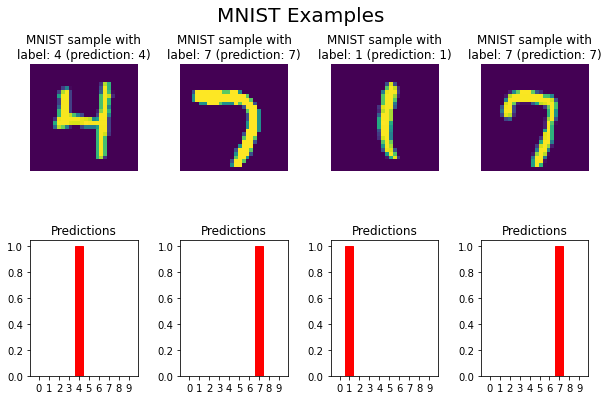

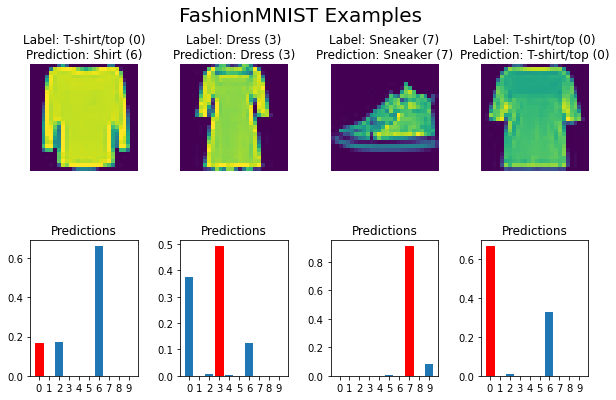

In [10]:
# Get a batch of test samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_test_batch(4)
fmnist_inps, fmnist_trgts = fmnist.next_test_batch(4)

# Compute predictions for test batches above.
with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')
    fmnist_X = mnist.input_to_torch_tensor(fmnist_inps, device, mode='inference')
    
    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)

    W_fmnist = hnet(cond_id=1)
    fmnist_preds = mnet.forward(fmnist_X, weights=W_fmnist)
    
    # Note, the network outputs are logits, and thus not normalized.
    mnist_preds = torch.softmax(mnist_preds, dim=1)
    fmnist_preds = torch.softmax(fmnist_preds, dim=1)
    
    mnist_preds = mnist_preds.detach().cpu().numpy()
    fmnist_preds = fmnist_preds.detach().cpu().numpy()

mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts,
                   predictions=mnist_preds)
fmnist.plot_samples('FashionMNIST Examples', fmnist_inps, outputs=fmnist_trgts,
                    predictions=fmnist_preds)